<h1><center>DSO 599 - Final Project - Code Only</center></h1>
<h2><center>Deep Learning Applications on SPX Volatility Forecasting</center></h2>
<h3><center>Francis Chen</center></h3>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import urllib.request as urlreq
import json
import os
import tensorflow.keras as keras
os.chdir('.\ModelWeights')

from matplotlib import pyplot
pd.options.display.float_format = '{:,.4f}'.format
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
### Collecting VIX and SPX index data from CBOE and Yahoo Finance

# VIX Data Collection
curr_vix = pd.read_csv('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv', 
                       skiprows = 1, index_col = 0)
curr_vix.index = pd.to_datetime(curr_vix.index)

hist_vix = pd.read_excel('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixarchive.xls',
                         skiprows = 1, index_col = 0)
hist_vix.index = pd.to_datetime(hist_vix.index)

vix = pd.concat([hist_vix,curr_vix], axis = 0)

# SPX Data Collection
ticker = '^GSPC'
start_date = dt.datetime(1990,1,1)
end_date = end_date = dt.datetime.today()

start_date_unix = int(start_date.timestamp())
end_date_unix = int(end_date.timestamp())

hist_price_url = 'https://query1.finance.yahoo.com/v8/finance/chart/{0}?symbol={0}&period1={1}&period2={2}&interval=1d'.format(ticker,start_date_unix,end_date_unix)

with urlreq.urlopen(hist_price_url) as url:
    data = json.loads(url.read().decode())
    hist_prices = pd.DataFrame({**data['chart']['result'][0]['indicators']['quote'][0], **data['chart']['result'][0]['indicators']['adjclose'][0]},
                               index = [dt.datetime.utcfromtimestamp(int(x)).date() for x in data['chart']['result'][0]['timestamp']])
    hist_prices.index = pd.to_datetime(hist_prices.index)
    hist_prices.columns = ["{0}_{1}".format(ticker.replace('^',''), x) for x in hist_prices.columns]


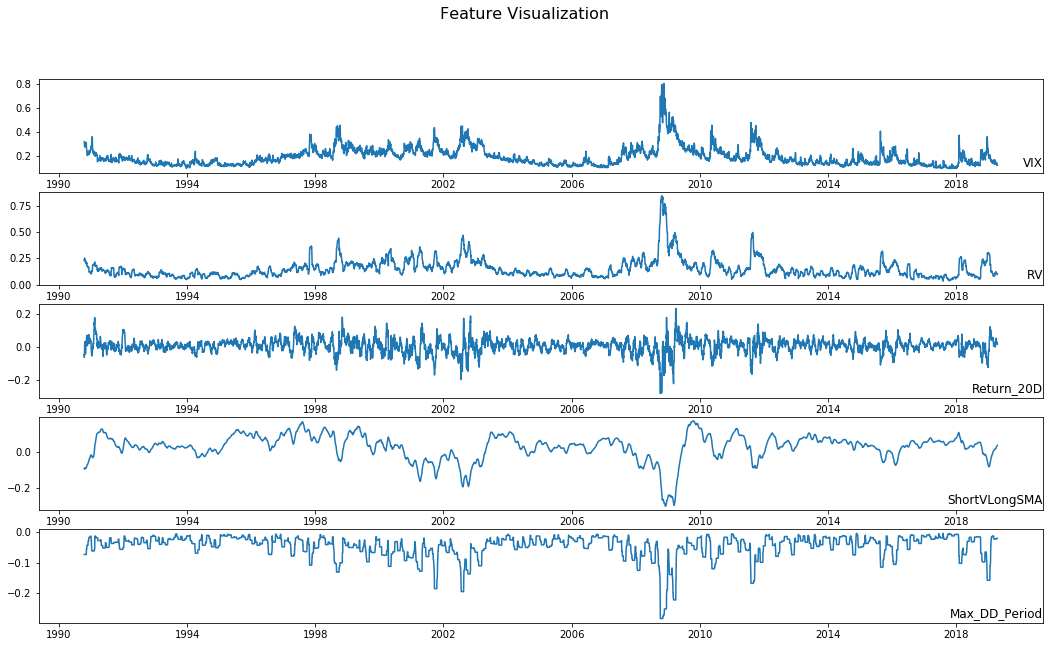

In [3]:
# Joining both VIX and SPX data into one dataframe and backfilling null values
data = pd.concat([hist_prices[['GSPC_close']], vix[['VIX Close']]], 
                 axis = 1).replace('n/a',np.nan).apply(lambda x: pd.to_numeric(x)).fillna(method = 'ffill')
data.columns = [col.replace('VIX Close','VIX') for col in data.columns.tolist()]

# Dividing VIX_Close by 100 given the index is a measure of implied future volatility
data['VIX'] = data['VIX']/100

# Calculating 20 Trading Day Rolling Realized Annualized Volatility for the SPX Index

data['RV'] = np.log(data['GSPC_close']/data['GSPC_close'].shift(1))**2
data['RV'] = np.sqrt(data['RV'].rolling(window = 20).mean()*252)

# Returns for 20 Day for the SPX Index
data['Return_20D'] = data.GSPC_close.pct_change(20)
    
# Short Period vs Long Period Simple Moving Average Measure
short_window = 20
long_window = 200
data['ShortVLongSMA'] = data.GSPC_close.rolling(window = short_window).mean()/data.GSPC_close.rolling(window = long_window).mean() - 1

data['Max_DD_Period'] = data.GSPC_close/data.GSPC_close.rolling(window = 20).max() - 1
data['Max_DD_Period'] = data['Max_DD_Period'].rolling(window = 20).min()
data = data.dropna().iloc[:,1:]

# Plotting Time Series of Features

pyplot.figure(figsize = (18,10))
for variable in range(data.shape[1]):
    pyplot.subplot(data.shape[1], 1, variable + 1)
    pyplot.plot(data.iloc[:, variable])
    pyplot.title(data.columns[variable], y = 0, loc = 'right')
pyplot.suptitle('Feature Visualization', size = 16)

In [4]:
# Function for splitting data into training, validation, and testing sets

def time_series_to_supervised_learning(data, timesteps = 1, y_col = 'VIX', train_pct = 0.6, validation_pct = 0.3):
    out_data = data.copy()
    out_data['{}_Prediction'.format(y_col)] = out_data[y_col].shift(-timesteps)
    out_data = out_data.dropna()
    
    train = out_data.iloc[:round(len(out_data)*train_pct),:]
    validation = out_data.iloc[len(train):len(train) + round(len(out_data)*validation_pct), :]
    test = out_data[out_data.index > validation.index[-1]]
    
    return train, validation, test

# Function for Splitting into input and outputs and normalizing and reshaping if required
def dataset_tensors(train, validation, test, rnn = True, normalize = False):
    
    if normalize:
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Fit transform on training data
        train_scaled = scaler.fit_transform(train)

        # Normalize data using fitted transform from training data
        validation_scaled = scaler.transform(validation)
        test_scaled = scaler.transform(test)

        # Splitting into input and outputs
        train_x, train_y = train_scaled[:, :-1], train_scaled[:, -1]
        validation_x, validation_y = validation_scaled[:, :-1], validation_scaled[:, -1]
        test_x, test_y = test_scaled[:, :-1], test_scaled[:, -1]
    else:
        
        # Splitting into input and outputs without normalizing
        train_x, train_y = train.values[:, :-1], train.values[:, -1]
        validation_x, validation_y = validation.values[:, :-1], validation.values[:, -1]
        test_x, test_y = test.values[:, :-1], test.values[:, -1]
    
    if rnn:
        # Reshaping data to be 3D [samples, timesteps, features] for tensor operations
        train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
        validation_x = validation_x.reshape((validation_x.shape[0], 1, validation_x.shape[1]))
        test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    
    
    print('Training Set Shapes: ', train_x.shape, train_y.shape)
    print('Validation Set Shapes: ',validation_x.shape, validation_y.shape)
    print('Test Set Shapes: ',test_x.shape, test_y.shape)
    
    return train_x, train_y, validation_x, validation_y, test_x, test_y

# Function for evaluating deep learning regression models
def model_evaluation(model, validation, test, validation_x, validation_y, test_x, test_y, rnn = True):
    
    # make a prediction
    yhat_validation = model.predict(validation_x).reshape(validation_y.shape)
    yhat_test = model.predict(test_x).reshape(test_y.shape)

    # calculate RMSE
    rmse_validation = np.sqrt(mean_squared_error(validation_y, yhat_validation))
    rmse_test = np.sqrt(mean_squared_error(test_y, yhat_test))
    
    validation_performance = pd.DataFrame({'VIX_Actual': validation_y,
                                           'VIX_Predicted': yhat_validation}).set_index(validation.index).shift(1).dropna()
    validation_performance.plot(figsize = (18,10), title = 'Validation Data Comparison')
    
    test_performance = pd.DataFrame({'VIX_Actual': test_y,
                                 'VIX_Predicted': yhat_test}).set_index(test.index).shift(1).dropna()
    test_performance.plot(figsize = (18,10), title = 'Test Data Comparison')
    
    print('Validation RMSE: %.3f' % rmse_validation)
    print('Test RMSE: %.3f' % rmse_test)

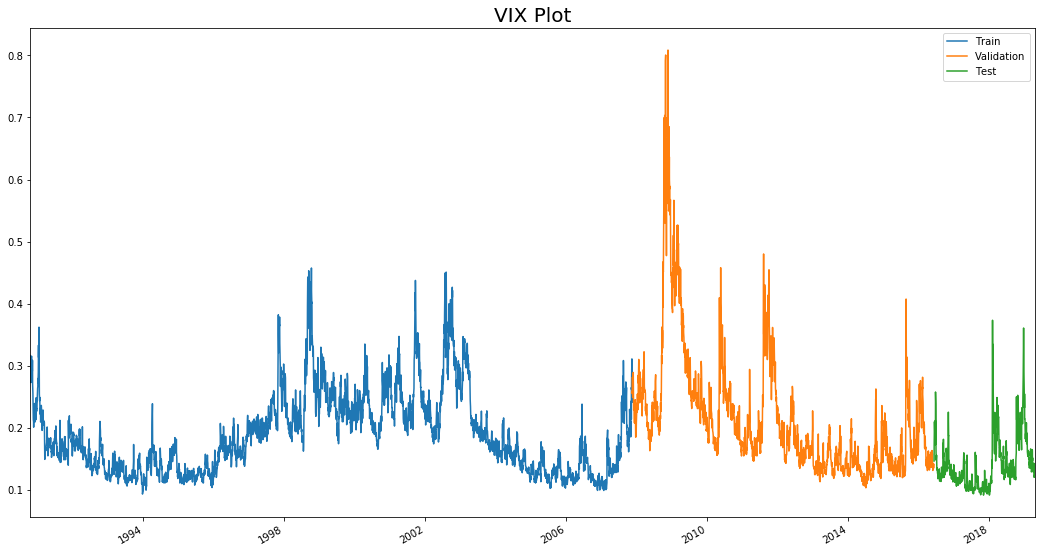

In [5]:
# LSTM Data Preparation
# Shifting timestep only 1 day
train, validation, test = time_series_to_supervised_learning(data)

# Plotting the data sets
pyplot.figure(figsize=(18, 10))
ax = train.VIX.plot()
validation.VIX.plot(ax=ax)
test.VIX.plot(ax=ax)
pyplot.legend(['Train', 'Validation', 'Test'])
pyplot.title('VIX Plot', size = 20)

In [6]:
# Since all features are between -1 and 1 by definition, normalization is unnecessary


# Splitting into input and outputs

# Reshaping data to be 3D [samples, timesteps, features] for tensor operations

train_x, train_y, validation_x, validation_y, test_x, test_y = dataset_tensors(train, validation, test, 
                                                                               rnn = True, normalize = False)

Training Set Shapes:  (4310, 1, 5) (4310,)
Validation Set Shapes:  (2155, 1, 5) (2155,)
Test Set Shapes:  (719, 1, 5) (719,)


W0418 21:55:29.153240  2600 deprecation.py:506] From C:\Users\Fang\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


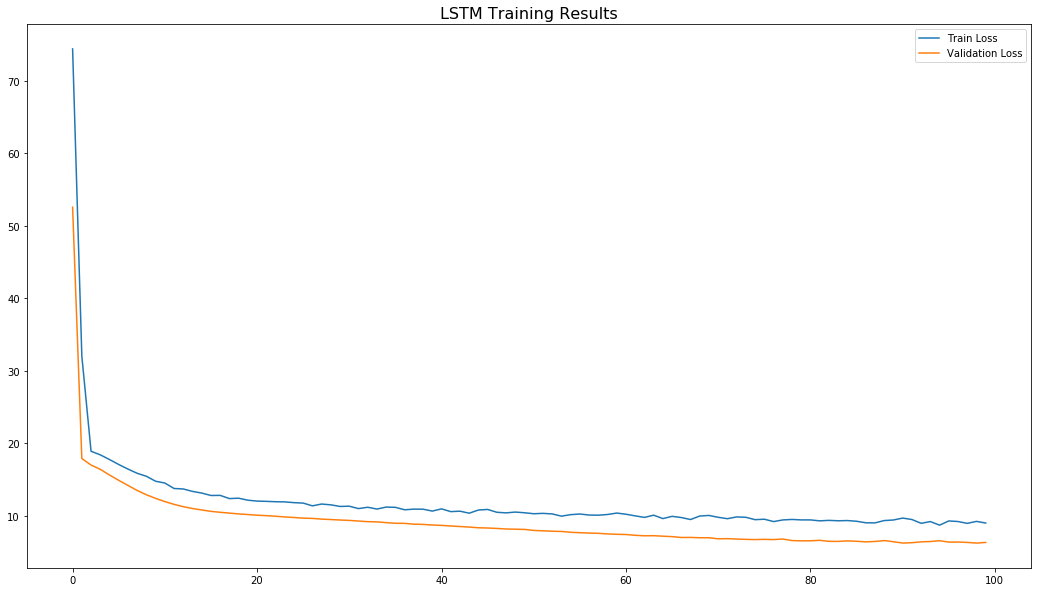

In [7]:
# design network
# 50 neurons with 100 Epochs with batch size of 200
neurons = 30
n_epochs = 100
batchsize = 200

model = keras.models.Sequential()
model.add(keras.layers.LSTM(neurons, input_shape=(train_x.shape[1], train_x.shape[2]), activation = 'tanh',
                            dropout=0.05))
model.add(keras.layers.Dense(1))
model.compile(loss = 'mean_absolute_percentage_error', optimizer = 'adam')

# fit network
checkpointer = keras.callbacks.ModelCheckpoint(filepath="LSTM_mae_weights.hdf5", verbose=0, save_best_only=True)

history = model.fit(train_x, train_y, epochs = n_epochs, 
                    batch_size = batchsize, validation_data=(validation_x, validation_y), 
                    verbose=0, shuffle=False, callbacks = [checkpointer])
# plot history
pyplot.figure(figsize=(18, 10))
pyplot.plot(history.history['loss'], label = 'Train Loss')
pyplot.plot(history.history['val_loss'], label = 'Validation Loss')
pyplot.title('LSTM Training Results', size = 16)
pyplot.legend()
pyplot.show()

Validation RMSE: 0.024
Test RMSE: 0.016


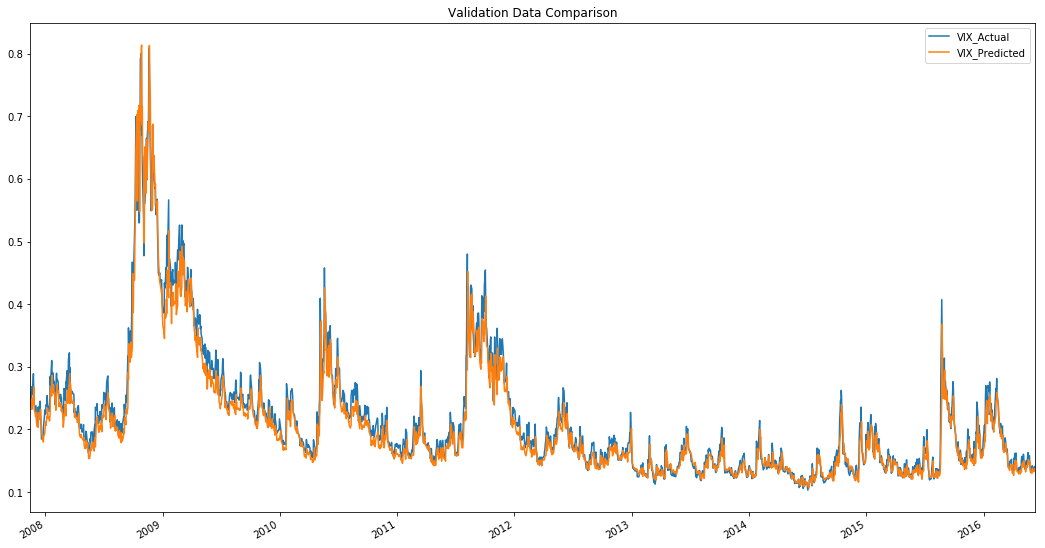

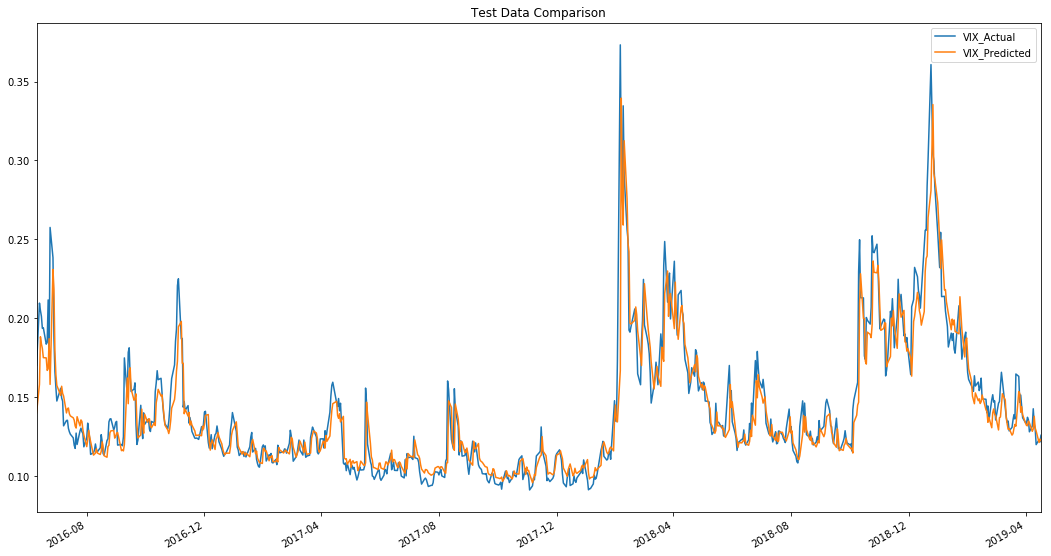

In [8]:
model_evaluation(model, validation, test, validation_x, validation_y, test_x, test_y, rnn = True)

In [9]:
# Using Simple MLP to predict 20 day out
# Splitting Data into Training, Validation, and Test sets

train, validation, test = time_series_to_supervised_learning(data)

# Splitting into input and outputs
train_x, train_y, validation_x, validation_y, test_x, test_y = dataset_tensors(train, validation, test, 
                                                                               rnn = False, normalize = False)

Training Set Shapes:  (4310, 5) (4310,)
Validation Set Shapes:  (2155, 5) (2155,)
Test Set Shapes:  (719, 5) (719,)


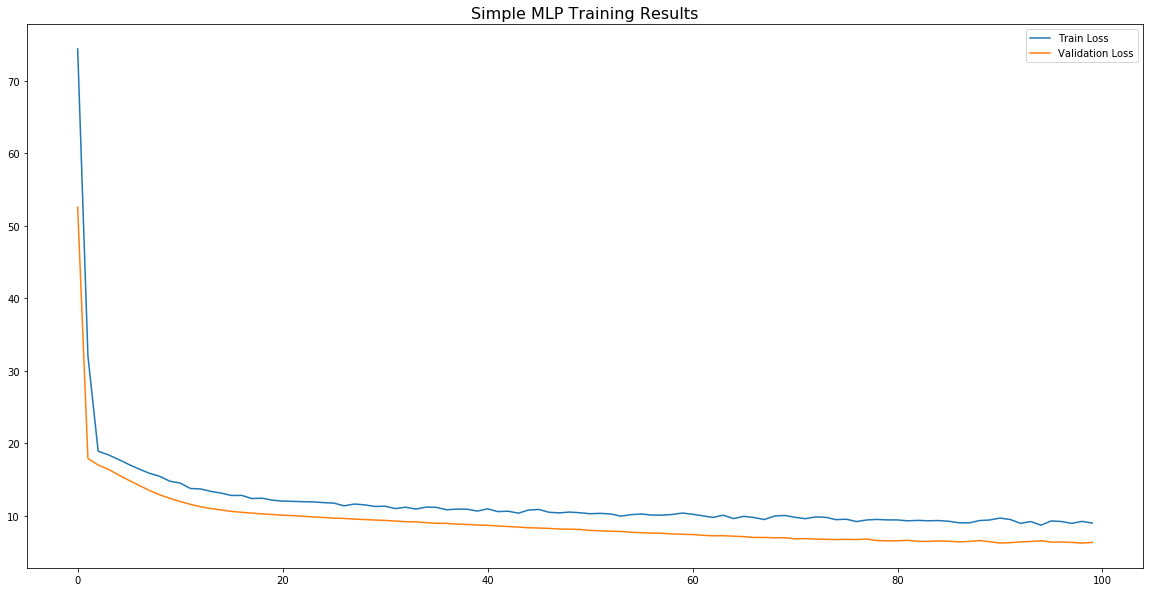

In [10]:
# design network
# 100 Epochs with batch size of 200

model_mlp = keras.models.Sequential()
model_mlp.add(keras.layers.Dense(9, input_dim = train_x.shape[1], activation = 'tanh'))
#model.add(keras.layers.Dropout(0.1))
#model_mlp.add(keras.layers.Dense(6, activation = 'tanh'))
model_mlp.add(keras.layers.Dense(1))
model_mlp.compile(loss='mean_absolute_percentage_error', optimizer='adam')
# fit network
checkpointer_mlp = keras.callbacks.ModelCheckpoint(filepath="MLP_mae_weights.hdf5", verbose=0, save_best_only=True)

history_mlp = model_mlp.fit(train_x, train_y, epochs = n_epochs, 
                            batch_size = batchsize, validation_data=(validation_x, validation_y), 
                            verbose=0, shuffle=False, callbacks = [checkpointer_mlp])
# plot history
pyplot.figure(figsize=(20, 10))
pyplot.plot(history.history['loss'], label='Train Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.title('Simple MLP Training Results', size = 16)
pyplot.legend()
pyplot.show()

Validation RMSE: 0.027
Test RMSE: 0.015


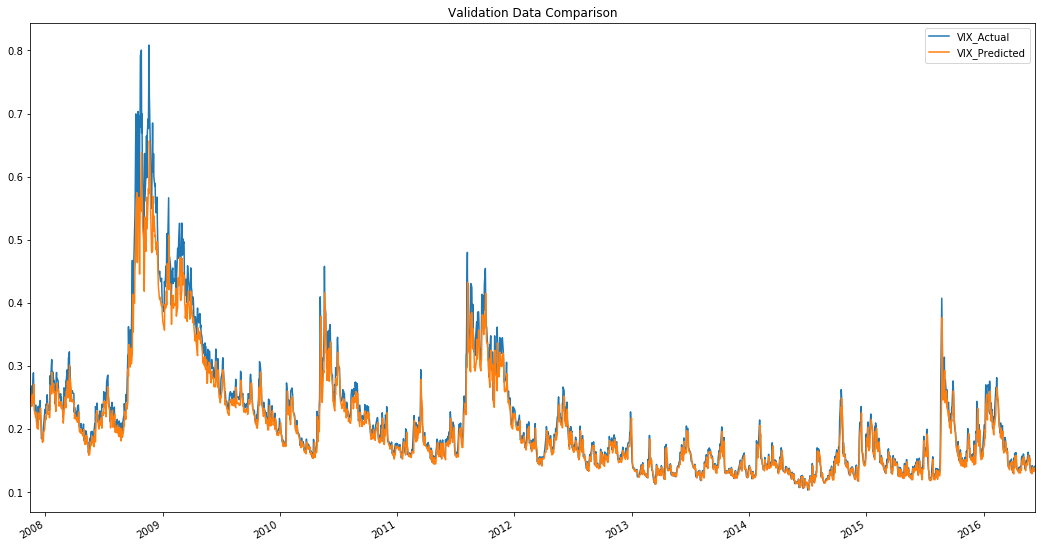

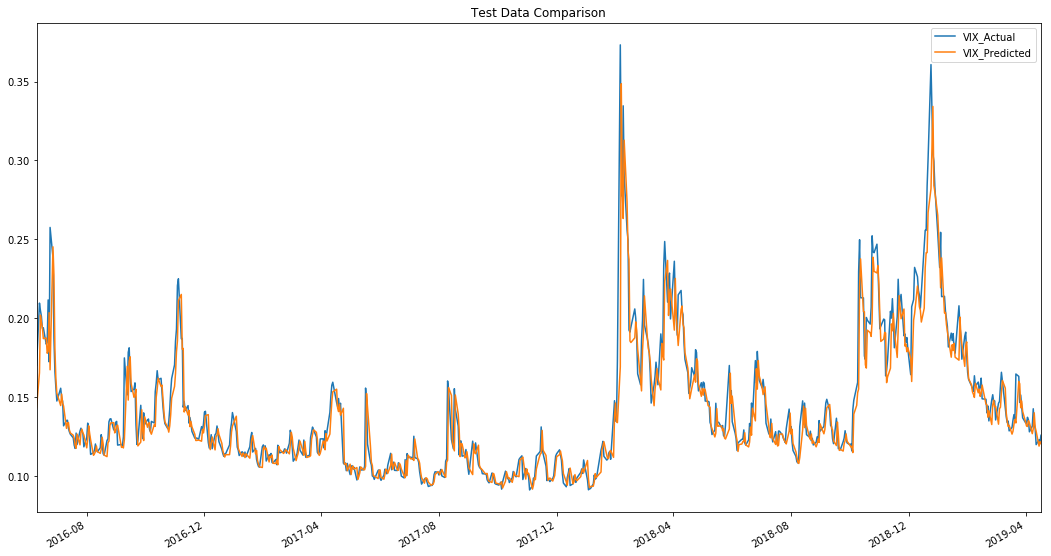

In [11]:
model_evaluation(model_mlp, validation, test, validation_x, validation_y, test_x, test_y, rnn = False)